In [1]:
import json
from collections import Counter, defaultdict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [3]:
plt.rcParams["font.size"] = 14
plt.rcParams['font.sans-serif'] = ['IPAexGothic']

In [4]:
def plot_freq(train_counts, savefig_path, xlabel='', ylabel=''):
    plt.figure()
    ax = train_counts.plot.bar(width=100.0, rot=0)
    ax.set_xticks(np.arange(0,len(train_counts),5000))
    ax.set_xticklabels(np.arange(0,len(train_counts),5000))
    ax.grid(which='major', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(-1000, len(train_counts)+1000)
    plt.savefig(savefig_path, bbox_inches='tight')

In [5]:
def count_unanswerable(target_dataset, train_counts):
    num_unanswerable = 0
    for _, item in target_dataset.iterrows():
        entity = item['entity']
        if entity not in train_counts:
            num_unanswerable += 1
    
    ratio_unanswerable = (1 - num_unanswerable / len(target_dataset)) 
    return num_unanswerable, ratio_unanswerable

In [6]:
def make_freq_accuracy_bins(prediction_path, train_counts, freq_bins):
    freq_bins = list(sorted(freq_bins))
    freq_accuracy_bins = defaultdict(list)
    
    with open(prediction_path) as f:
        for line in f:
            pred_data = json.loads(line)
            pred_answer = pred_data['top10_labels'][0]
            correct_answer = pred_data['metadata']['entity']
            sid = pred_data['metadata'].get('sentence_index')
            
            accuracy = int(pred_answer == correct_answer)

            if correct_answer in train_counts:
                freq = train_counts[correct_answer]
            else:
                freq = 0
            
            for bin_label in freq_bins[::-1]:
                if freq >= bin_label:
                    break
            else:
                continue
            
            freq_accuracy_bins[bin_label].append(accuracy)
                
    freq_mean_accuracies = defaultdict(float)
    for i, bin_label in enumerate(freq_bins):
        accuracies = freq_accuracy_bins[bin_label]
        assert len(accuracies) > 0
        mean_accuracy = sum(accuracies) / len(accuracies)
        if i < len(freq_bins) - 1 and freq_bins[i + 1] - bin_label == 1:
            freq_mean_accuracies[bin_label] = mean_accuracy
        else:
            freq_mean_accuracies[f'{bin_label}+'] = mean_accuracy
        
        last_label = bin_label
            
    return freq_mean_accuracies

In [7]:
def make_sid_accuracy_bins(prediction_path):
    sid_accuracy_bins = defaultdict(list)
    
    with open(prediction_path) as f:
        for line in f:
            pred_data = json.loads(line)
            pred_answer = pred_data['top10_labels'][0]
            correct_answer = pred_data['metadata']['entity']
            sid = pred_data['metadata'].get('sentence_index')
            
            accuracy = int(pred_answer == correct_answer)
            
            if sid is not None:
                sid += 1  # 0-origin -> 1-origin
                sid_label = '7+' if sid >= 7 else str(sid)
                sid_accuracy_bins[sid_label].append(accuracy)
        
    sid_mean_accuracies = defaultdict(float)
    for label in ['1', '2', '3', '4', '5', '6', '7+']:
        if label in sid_accuracy_bins:
            accuracies = sid_accuracy_bins[label]
            assert len(accuracies) > 0
            mean_accuracy = sum(accuracies) / len(accuracies)
            sid_mean_accuracies[label] = mean_accuracy
            
    return sid_mean_accuracies

In [8]:
def plot_accuracies(accuracies, savefig_path, xlabel='', ylabel=''):
    plt.figure()
    ax = accuracies.plot.bar(rot=0)
    ax.grid(which='major', axis='y', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=12)
    plt.savefig(savefig_path, bbox_inches='tight')

## Quizbowl

In [9]:
QB_TRAIN_PATH = "work/dataset/quizbowl/train_question.json"
QB_DEV_PATH = "work/dataset/quizbowl/dev_question.json"
QB_EVAL_PATH = "work/dataset/quizbowl/eval_question.json"
QB_TEST_PATH = "work/dataset/quizbowl/test_question.json"

In [10]:
qb_train = pd.read_json(open(QB_TRAIN_PATH).read(), orient='records', lines=True)
qb_dev = pd.read_json(open(QB_DEV_PATH).read(), orient='records', lines=True)
qb_eval = pd.read_json(open(QB_EVAL_PATH).read(), orient='records', lines=True)
qb_test = pd.read_json(open(QB_TEST_PATH).read(), orient='records', lines=True)

In [11]:
qb_train.head()

,qanta_id,text,entity,text_unit
0,0,After this character relates a story about how...,Queequeg,question
1,1,The oldest document written in this language i...,Romanian_language,question
2,2,This state's largest city endured an 1855 Rum ...,Maine,question
3,3,"In one work, this man provides definitions for...",Charles_Sanders_Peirce,question
4,4,One family in this work flees France after res...,Frankenstein,question


In [12]:
qb_train_counts = qb_train['entity'].value_counts()
print(qb_train_counts)

Japan                   99
China                   97
Australia               97
Spain                   89
Brazil                  87
                        ..
Ernest_P._Worrell        1
Acne                     1
Grand_Admiral_Thrawn     1
Publishing               1
Suger                    1
Name: entity, Length: 25969, dtype: int64


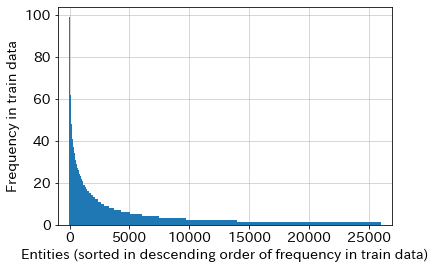

In [13]:
plot_freq(qb_train_counts,
          savefig_path='images/quizbowl_train_freq.pdf',
          xlabel='Entities (sorted in descending order of frequency in train data)',
          ylabel='Frequency in train data')

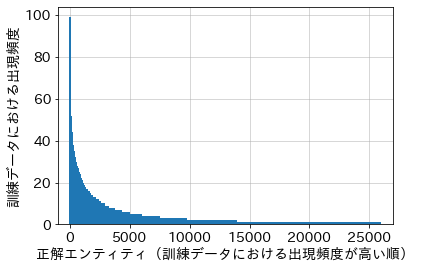

In [14]:
plot_freq(qb_train_counts,
          savefig_path='images/quizbowl_train_freq_ja.pdf',
          xlabel='正解エンティティ（訓練データにおける出現頻度が高い順）',
          ylabel='訓練データにおける出現頻度')

In [15]:
count_unanswerable(qb_dev, qb_train_counts)

(0, 1.0)

In [16]:
count_unanswerable(qb_eval, qb_train_counts)

(307, 0.8614620938628159)

In [17]:
count_unanswerable(qb_test, qb_train_counts)

(648, 0.8421052631578947)

In [18]:
QB_EVAL_PRED_QUIZ_PATH = 'work/quizbowl/quiz/bert-base/prediction_eval_question.json'
QB_EVAL_PRED_WIKI_TO_QUIZ_PATH = 'work/quizbowl/wiki_to_quiz/bert-base/prediction_eval_question.json'

In [19]:
freq_bins = [1, 2, 5, 10]
qb_freq_accuracies_quiz = make_freq_accuracy_bins(QB_EVAL_PRED_QUIZ_PATH, qb_train_counts, freq_bins)
qb_freq_accuracies_wiki_to_quiz = make_freq_accuracy_bins(QB_EVAL_PRED_WIKI_TO_QUIZ_PATH, qb_train_counts, freq_bins)

In [20]:
freq_labels = qb_freq_accuracies_quiz.keys()
qb_freq_accuracies = pd.DataFrame(
    data={
        'Quiz': [qb_freq_accuracies_quiz[label] for label in freq_labels],
        r'Wiki$\rightarrow$Quiz': [qb_freq_accuracies_wiki_to_quiz[label] for label in freq_labels]
    },
    index=freq_labels)

In [21]:
qb_freq_accuracies

,Quiz,Wiki$\rightarrow$Quiz
1,0.365000,0.510000
2+,0.704000,0.789333
5+,0.844193,0.889518
10+,0.902141,0.910296


<Figure size 432x288 with 0 Axes>

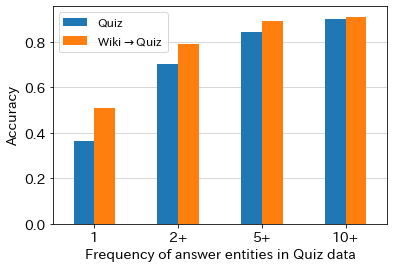

In [22]:
plot_accuracies(qb_freq_accuracies,
                savefig_path='images/quizbowl_freq_accuracies.pdf',
                xlabel='Frequency of answer entities in Quiz data',
                ylabel='Accuracy')

<Figure size 432x288 with 0 Axes>

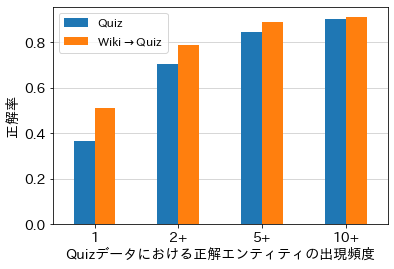

In [23]:
plot_accuracies(qb_freq_accuracies,
                savefig_path='images/quizbowl_freq_accuracies_ja.pdf',
                xlabel='Quizデータにおける正解エンティティの出現頻度',
                ylabel='正解率')

In [24]:
QB_DEV_PRED_QUIZ_SENT_PATH = 'work/quizbowl/quiz/bert-base/prediction_eval_sentence.json'
QB_DEV_PRED_WIKI_TO_QUIZ_SENT_PATH = 'work/quizbowl/wiki_to_quiz/bert-base/prediction_eval_sentence.json'

In [25]:
qb_sid_accuracies_quiz = make_sid_accuracy_bins(QB_DEV_PRED_QUIZ_SENT_PATH)
qb_sid_accuracies_wiki_to_quiz = make_sid_accuracy_bins(QB_DEV_PRED_WIKI_TO_QUIZ_SENT_PATH)

In [26]:
sid_labels = qb_sid_accuracies_quiz.keys()
sid_accuracies = pd.DataFrame(
    data={
        'Quiz': [qb_sid_accuracies_quiz[label] for label in sid_labels],
        r'Wiki$\rightarrow$Quiz': [qb_sid_accuracies_wiki_to_quiz[label] for label in sid_labels]
    },
    index=sid_labels)

In [27]:
sid_accuracies

,Quiz,Wiki$\rightarrow$Quiz
1,0.148014,0.180505
2,0.218863,0.266245
3,0.300090,0.347473
4,0.398917,0.451264
5,0.477399,0.527214
6,0.528323,0.589456
7+,0.556396,0.599725


<Figure size 432x288 with 0 Axes>

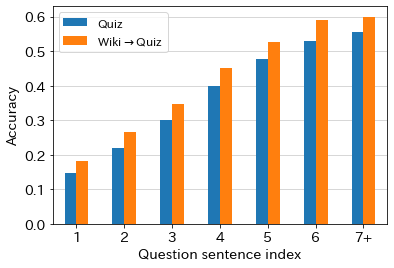

In [28]:
plot_accuracies(sid_accuracies,
                savefig_path='images/quizbowl_sid_accuracies.pdf',
                xlabel='Question sentence index',
                ylabel='Accuracy')

## TriviaQA

In [29]:
TQ_TRAIN_PATH = "work/dataset/triviaqa/train_question.json"
TQ_DEV_PATH = "work/dataset/triviaqa/dev_question.json"
TQ_EVAL_PATH = "work/dataset/triviaqa/dev_question.json"
TQ_WIKI_PATH = "work/dataset/triviaqa/wiki_sentence_blingfire.json"

In [30]:
tq_train = pd.read_json(open(TQ_TRAIN_PATH).read(), orient='records', lines=True)
tq_dev = pd.read_json(open(TQ_DEV_PATH).read(), orient='records', lines=True)
tq_eval = pd.read_json(open(TQ_EVAL_PATH).read(), orient='records', lines=True)
tq_wiki = pd.read_json(open(TQ_WIKI_PATH).read(), orient='records', lines=True)

In [31]:
tq_train.head()

,question_id,text,entity
0,tc_0,Who was President when the first Peanuts carto...,Harry_S._Truman
1,tc_1,Which American-born Sinclair won the Nobel Pri...,Sinclair_Lewis
2,tc_3,Where in England was Dame Judi Dench born?,York
3,tc_5,In which decade did Billboard magazine first p...,30s
4,tc_8,From which country did Angola achieve independ...,Portugal


In [32]:
tq_train_counts = tq_train['entity'].value_counts()

In [33]:
tq_train_counts

Australia                 153
France                    133
New_Zealand               114
Spain                     102
South_Africa              100
                         ... 
Butte                       1
Midas_(disambiguation)      1
Relatives                   1
Tight_Fit                   1
1170s                       1
Name: entity, Length: 28689, dtype: int64

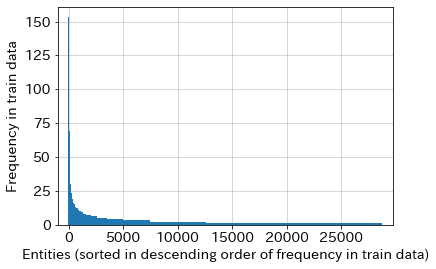

In [34]:
plot_freq(tq_train_counts,
          savefig_path='images/triviaqa_train_freq.pdf',
          xlabel='Entities (sorted in descending order of frequency in train data)',
          ylabel='Frequency in train data')

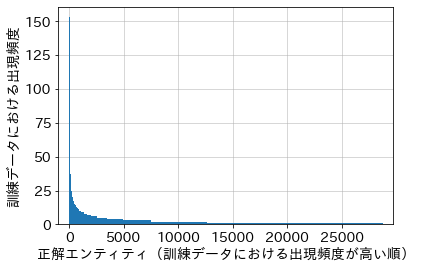

In [35]:
plot_freq(tq_train_counts,
          savefig_path='images/triviaqa_train_freq_ja.pdf',
          xlabel='正解エンティティ（訓練データにおける出現頻度が高い順）',
          ylabel='訓練データにおける出現頻度')

In [36]:
TQ_EVAL_PRED_QUIZ_PATH = 'work/triviaqa/quiz/bert-base_30ep/prediction_eval_question.json'
TQ_EVAL_PRED_WIKI_TO_QUIZ_PATH = 'work/triviaqa/wiki_to_quiz/bert-base/prediction_eval_question.json'

In [37]:
freq_bins = [1, 2, 5, 10]
tq_freq_accuracies_quiz = make_freq_accuracy_bins(TQ_EVAL_PRED_QUIZ_PATH, tq_train_counts, freq_bins)
tq_freq_accuracies_wiki_to_quiz = make_freq_accuracy_bins(TQ_EVAL_PRED_WIKI_TO_QUIZ_PATH, tq_train_counts, freq_bins)

In [38]:
freq_labels = tq_freq_accuracies_quiz.keys()
tq_freq_accuracies = pd.DataFrame(
    data={
        'Quiz': [tq_freq_accuracies_quiz[label] for label in freq_labels],
        r'Wiki$\rightarrow$Quiz': [tq_freq_accuracies_wiki_to_quiz[label] for label in freq_labels]
    },
    index=freq_labels)

In [39]:
tq_freq_accuracies

,Quiz,Wiki$\rightarrow$Quiz
1,0.275407,0.440041
2+,0.437993,0.560879
5+,0.492013,0.587061
10+,0.447461,0.543992


<Figure size 432x288 with 0 Axes>

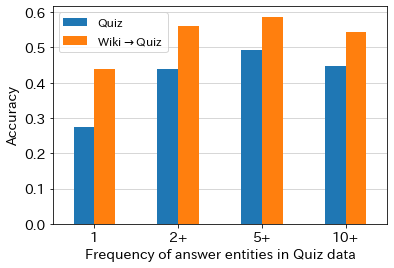

In [40]:
plot_accuracies(tq_freq_accuracies,
                savefig_path='images/triviaqa_freq_accuracies.pdf',
                xlabel='Frequency of answer entities in Quiz data',
                ylabel='Accuracy')

<Figure size 432x288 with 0 Axes>

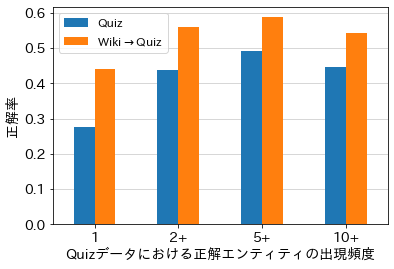

In [41]:
plot_accuracies(tq_freq_accuracies,
                savefig_path='images/triviaqa_freq_accuracies_ja.pdf',
                xlabel='Quizデータにおける正解エンティティの出現頻度',
                ylabel='正解率')

### Plotting

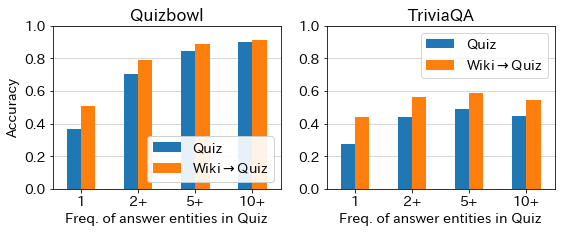

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
qb_freq_accuracies.plot.bar(ax=axes[0], ylim=(0.0, 1.0), rot=0, title='Quizbowl')
axes[0].grid(which='major', axis='y', linewidth=0.5)
axes[0].set_axisbelow(True)
axes[0].set_xlabel('Freq. of answer entities in Quiz')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right', framealpha=0.9)
tq_freq_accuracies.plot.bar(ax=axes[1], ylim=(0.0, 1.0), rot=0, title='TriviaQA')
axes[1].grid(which='major', axis='y', linewidth=0.5)
axes[1].set_axisbelow(True)
axes[1].set_xlabel('Freq. of answer entities in Quiz')
plt.savefig('images/freq_accuracies.pdf', bbox_inches='tight')

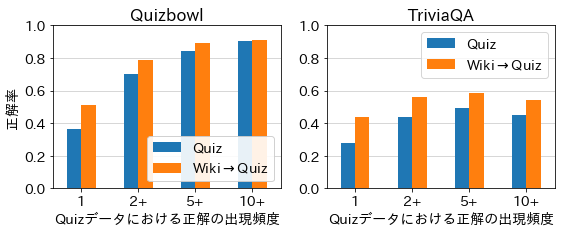

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
qb_freq_accuracies.plot.bar(ax=axes[0], ylim=(0.0, 1.0), rot=0, title='Quizbowl')
axes[0].grid(which='major', axis='y', linewidth=0.5)
axes[0].set_axisbelow(True)
axes[0].set_xlabel('Quizデータにおける正解の出現頻度')
axes[0].set_ylabel('正解率')
axes[0].legend(loc='lower right', framealpha=0.9)
tq_freq_accuracies.plot.bar(ax=axes[1], ylim=(0.0, 1.0), rot=0, title='TriviaQA')
axes[1].grid(which='major', axis='y', linewidth=0.5)
axes[1].set_axisbelow(True)
axes[1].set_xlabel('Quizデータにおける正解の出現頻度')
plt.savefig('images/freq_accuracies_ja.pdf', bbox_inches='tight')

### Qualitative Analysis

In [44]:
TQ_TRAIN_PATH = "work/dataset/triviaqa/train_question.json"
TQ_DEV_PATH = "work/dataset/triviaqa/dev_question.json"
TQ_DEV_PRED_QUIZ_PATH = 'work/triviaqa/quiz/bert-base_30ep/prediction_dev_question.json'
TQ_DEV_PRED_WIKI_TO_QUIZ_PATH = 'work/triviaqa/wiki_to_quiz/bert-base/prediction_dev_question.json'
TQ_WIKI_PATH = "work/dataset/triviaqa/wiki_sentence_blingfire.json"

In [45]:
tq_train = pd.read_json(open(TQ_TRAIN_PATH).read(), orient='records', lines=True)
tq_dev = pd.read_json(open(TQ_DEV_PATH).read(), orient='records', lines=True)
tq_wiki = pd.read_json(open(TQ_WIKI_PATH).read(), orient='records', lines=True)

In [46]:
tq_train_counts = tq_train['entity'].value_counts()
tq_wiki_counts = tq_wiki['entity'].value_counts()

In [47]:
tq_dev_pred_quiz = pd.read_json(open(TQ_DEV_PRED_QUIZ_PATH).read(), orient='records', lines=True)
tq_dev_pred_wiki_to_quiz = pd.read_json(open(TQ_DEV_PRED_WIKI_TO_QUIZ_PATH).read(), orient='records', lines=True)

In [48]:
tq_dev_pred = tq_dev.join(tq_dev_pred_quiz).join(tq_dev_pred_wiki_to_quiz, lsuffix='_quiz', rsuffix='_wiki_to_quiz')

In [49]:
tq_dev_pred

,question_id,text,entity,metadata_quiz,top10_labels_quiz,rank_quiz,metadata_wiki_to_quiz,top10_labels_wiki_to_quiz,rank_wiki_to_quiz
0,tc_33,Which Lloyd Webber musical premiered in the US...,Sunset_Boulevard,"{'question_id': 'tc_33', 'text': 'Which Lloyd ...","[Cat, Cats_(disambiguation), Jesus_Christ_Supe...",72,"{'question_id': 'tc_33', 'text': 'Which Lloyd ...","[The_Lion_King, Starlight_Express, Cats_(disam...",63
1,tc_40,Who was the next British Prime Minister after ...,Henry_Campbell-Bannerman,"{'question_id': 'tc_40', 'text': 'Who was the ...","[James_Callaghan, Alec_Douglas-Home, Tony_Blai...",233,"{'question_id': 'tc_40', 'text': 'Who was the ...","[David_Lloyd_George, Stanley_Baldwin, Bonar_La...",60
2,tc_56,What claimed the life of singer Kathleen Ferrier?,Cancer,"{'question_id': 'tc_56', 'text': 'What claimed...","[Loch_Ness_Monster, Santa_Claus, Ned_Kelly, Th...",9097,"{'question_id': 'tc_56', 'text': 'What claimed...","[Peter_Sutcliffe, Jack_the_Ripper, Charles_Man...",14507
3,tc_106,Which actress was voted Miss Greenwich Village...,Lauren_Bacall,"{'question_id': 'tc_106', 'text': 'Which actre...","[Debbie_Reynolds, Elizabeth_Taylor, Marilyn_Mo...",16,"{'question_id': 'tc_106', 'text': 'Which actre...","[Elizabeth_Taylor, Lana_Turner, Lauren_Bacall,...",3
4,tc_217,Which volcano in Tanzania is the highest mount...,Mount_Kilimanjaro,"{'question_id': 'tc_217', 'text': 'Which volca...","[Mount_Kilimanjaro, Mount_Kenya, Aconcagua, Do...",1,"{'question_id': 'tc_217', 'text': 'Which volca...","[Mount_Kilimanjaro, Mount_Kenya, Kenya, Lake_T...",1
...,...,...,...,...,...,...,...,...,...
5994,qg_4549,"Where do you find the Bridal Veil, American, a...",Niagara_Falls,"{'question_id': 'qg_4549', 'text': 'Where do y...","[Niagara_Falls, Washington, San_Francisco, Phi...",1,"{'question_id': 'qg_4549', 'text': 'Where do y...","[Niagara_Falls, Disneyland, Jungle_Cruise, New...",1
5995,qg_4592,Whose backing band is known as The Miami Sound...,Gloria_Estefan,"{'question_id': 'qg_4592', 'text': 'Whose back...","[David_Bowie, U2, Phil_Collins, Green_Day, Bru...",3469,"{'question_id': 'qg_4592', 'text': 'Whose back...","[Jools_Holland, Sting, Justin_Timberlake, Glor...",4
5996,qg_4604,"With a motto of Always Ready, Always There, wh...",National_Guard,"{'question_id': 'qg_4604', 'text': 'With a mot...","[United_States_Coast_Guard, Federal_Bureau_of_...",14,"{'question_id': 'qg_4604', 'text': 'With a mot...","[United_States_Coast_Guard, United_States_Mari...",6
5997,qg_4628,What is the name of the parson mentioned in th...,Brown,"{'question_id': 'qg_4628', 'text': 'What is th...","[Jack, Santa_Claus, Hatmaking, Polly, Lewis_Ca...",7528,"{'question_id': 'qg_4628', 'text': 'What is th...","[Dasher, Jack, God_Rest_You_Merry,_Gentlemen, ...",9771


In [50]:
tq_dev_pred_still_good = tq_dev_pred.query('rank_quiz == 1 and rank_wiki_to_quiz == 1')
tq_dev_pred_got_better = tq_dev_pred.query('rank_quiz > 1 and rank_wiki_to_quiz == 1')
tq_dev_pred_got_worse = tq_dev_pred.query('rank_quiz == 1 and rank_wiki_to_quiz > 1')
tq_dev_pred_still_bad = tq_dev_pred.query('rank_quiz > 1 and rank_wiki_to_quiz > 1')

In [51]:
len(tq_dev_pred_still_good), len(tq_dev_pred_got_better), len(tq_dev_pred_got_worse), len(tq_dev_pred_still_bad)

(2309, 936, 245, 2509)

In [52]:
def print_instances_in_md(df):
    for t in df.itertuples():
        print('**Quiestion ID:**', t.question_id)
        print('**Q.**', t.text)
        print('**A.**', t.entity)
        print('**Training Questions:**')
        for question in tq_train.query(f'entity == "{t.entity}"')['text'].tolist():
            print('-', question)
        
        print('**Hinting Wikipedia Sentences:**')
        print('-')
        print('**Rank (Quiz, Wiki->Quiz):**', t.rank_quiz, '->', t.rank_wiki_to_quiz)
        print('**Top 10 (Quiz):**', ', '.join([f'{l} ({tq_train_counts[l]})' for l in t.top10_labels_quiz]))
        print('**Top 10 (Wiki->Quiz):**', ', '.join([f'{l} ({tq_train_counts[l]}+{tq_wiki_counts[l]})' if l in tq_wiki_counts else f'{l} ({tq_train_counts[l]})' for l in t.top10_labels_wiki_to_quiz]))
        print()

In [53]:
print_instances_in_md(tq_dev_pred_still_good.sample(20, random_state=0))

**Quiestion ID:** qz_5462
**Q.** Who painted Girl with a Pearl Earring?
**A.** Johannes_Vermeer
**Training Questions:**
- Which 17th century Dutch painter did the forger Hans van Meegeren most often copy?
- "Who painted ""Girl reading a letter"" ?"
- "Which painter, born in Delft, produced works including ""The Woman With A Water Jug"", ""The Pianist"" and ""The Lacemaker""?"
- "The painting ""the Girl with the Pearl Earring"" is by which artist?"
- Who painted 'Girl with a Pearl Earring' in 1665?
- "Who painted ""Girl with a Pearl Earring"" circa 1665?"
- Born in Delft in 1632, he painted small detailed domestic scenes notable for their treatment of various tones of daylight. Who was he?
- 'View Of Delft' is one of the best known works of which 17th century artist?
**Hinting Wikipedia Sentences:**
-
**Rank (Quiz, Wiki->Quiz):** 1 -> 1
**Top 10 (Quiz):** Johannes_Vermeer (8), Diego_Velázquez (5), Frida_Kahlo (3), John_Everett_Millais (13), Andrew_Wyeth (1), PICASSO (4), Velazquez (1), 

In [54]:
print_instances_in_md(tq_dev_pred_got_better.sample(20, random_state=0))

**Quiestion ID:** odql_13875
**Q.** American country singer Waylon Jennings gave up his seat on a plane in February 1959 to J P Richardson. How was Richardson commonly known?
**A.** The_Big_Bopper
**Training Questions:**
- Late US singer/songwriter Jiles Perry Richardson Jr, born October 1930, was better known by what name?
- "What was the stage name of Jiles Perry Richardson, Jr., a singer and songwriter from 1957 until his accidental death in 1959, who is best known for his recording of ""Chantilly Lace""?"
- Give the pseudonym of J.P. Richardson, a pop singer , who dies in a plane crash in 1959?
- Singer Jiles Perry (JP) Richardson was better known as who?
- February 3, 1959 was known as The Day the Music Died, as a plane crash in Clearlake, Ia, took the life of Roger Peterson, Buddy Holly, Ritchie Valens, and who?
**Hinting Wikipedia Sentences:**
-
**Rank (Quiz, Wiki->Quiz):** 2 -> 1
**Top 10 (Quiz):** Waylon_Jennings (3), The_Big_Bopper (5), Will_Rogers (1), Rosa_Parks (2), Sugar_

In [55]:
print_instances_in_md(tq_dev_pred_got_worse.sample(20, random_state=0))

**Quiestion ID:** qw_7952
**Q.** Who was the first US president to succeed to the Presidency upon the assassination of his predecessor and the first US President to be impeached?
**A.** Andrew_Johnson
**Training Questions:**
- Who immediately succeeded Abraham Lincoln as President?
- Who succeeded Abraham Lincoln as US president in 1865?
- Who was Abraham Lincoln’s vice president when he was assassinated?
- May 26, 1868 saw the first impeachment trial in the US, when which US President, the 17th, was charged with illegally removing a cabinet member?
**Hinting Wikipedia Sentences:**
-
**Rank (Quiz, Wiki->Quiz):** 1 -> 2
**Top 10 (Quiz):** Andrew_Johnson (4), Roosevelt (2), Richard_Nixon (35), John_Adams (12), Dick_Cheney (4), Gerald_Ford (29), James_A._Garfield (6), John_Tyler (2), William_Howard_Taft (7), Walter_Mondale (8)
**Top 10 (Wiki->Quiz):** Robert_Jenkinson,_2nd_Earl_of_Liverpool (7+101), Andrew_Johnson (4+577), Lincoln (17+2), John_Tyler (2+495), Richard_Nixon (35+605), Impeac

**Hinting Wikipedia Sentences:**
-
**Rank (Quiz, Wiki->Quiz):** 1 -> 3
**Top 10 (Quiz):** New_Orleans (18), Chicago (56), Warsaw (9), Salzburg (5), Paris_(disambiguation) (16), Montreal (20), Los_Angeles (20), Milan (11), Venice (40), River_City (1)
**Top 10 (Wiki->Quiz):** Chicago (56+570), New_York (70+2), New_Orleans (18+567), Boston (27+371), Detroit (21+608), Montreal (20+390), Cleveland (6+455), St._Louis (11+457), Milwaukee (5+484), London (54+523)



In [56]:
print_instances_in_md(tq_dev_pred_still_bad.sample(20, random_state=0))

**Quiestion ID:** dpql_3627
**Q.** What literally means ‘submission to God’ in Arabic?
**A.** Islam
**Training Questions:**
- The book The Satanic Verses by Salman Rushdie caused controversy after it was claimed it was blasphemous against which religion?
- Muharram is the first month in which religious calender?
- July 16 in our Western calendar coincides with the first day of which other calendar?
- The word 'haram' refers to both a sanctuary and a forbidden act in which religion?
- The vast majority of Indonesian people adhere to what religion?
- Which new year has ever started on 16 July?
- The Koran is the sacred book of which religion?
- Which religion features the Five Duties or the Five Pillars?
- "A ""mufti"" is a legal expert in what religion?"
- "An ""imam"" is from which religion?"
- Followers of which religion observe Ramadan?
- The Dome of the Rock on the Temple Mount in Jerusalem is a shrine for which religion?
- Shi'ite and Sunni are beliefs within what religion?
- Which

- In which country are the Harz mountains?
- Which country's TV market is the largest in Western Europe, with 34m connected homes?
- "ANAGRAMS - Which country is an anagram of the female film star famous mostly for her roles in ""When Harry met Sally"" and ""Sleepless in Seattle""?"
- Which was the first country to introduce Old Age Pensions?
- Which country was the birthplace of Henry V111’s fourth wife Anne Of Cleeves ?
- In 2004, the post office of which country (international dialling code 49) gave away twenty million free scented stickers, to make Christmas cards smell like fir trees, cinammon, gingerbread or honey wax?
- In what country was the game Chinese Checkers (or Chinese Chequers) invented?
- The defence minister of which European country resigned in 2011, after he was found to have copied large parts of his 2006 university doctorate thesis?
- What nation ended conscription to its Bundeswehr in 2011?
- In 1901 the artists Wassily Kandinsky, Rolf Niczky, Waldemar Hecker, an

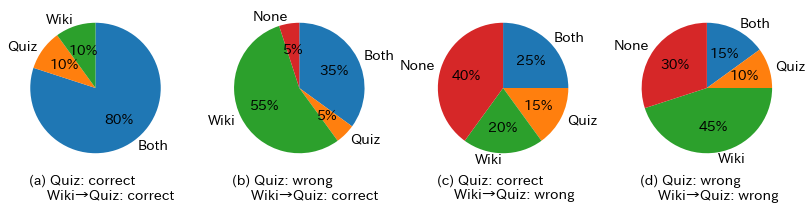

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 3))
axes[0].set_xlabel('(a) Quiz: correct       \n        Wiki→Quiz: correct')
axes[0].pie([16, 2, 2], labels=['Both', 'Quiz', 'Wiki'], counterclock=False, startangle=90, autopct="%.f%%")
axes[1].set_xlabel('(b) Quiz: wrong         \n        Wiki→Quiz: correct')
axes[1].pie([7, 1, 11, 1], labels=['Both', 'Quiz', 'Wiki', 'None'], counterclock=False, startangle=90, autopct="%.f%%")
axes[2].set_xlabel('(c) Quiz: correct       \n        Wiki→Quiz: wrong  ')
axes[2].pie([5, 3, 4, 8], labels=['Both', 'Quiz', 'Wiki', 'None'], counterclock=False, startangle=90, autopct="%.f%%")
axes[3].set_xlabel('(d) Quiz: wrong         \n        Wiki→Quiz: wrong  ')
axes[3].pie([3, 2, 9, 6], labels=['Both', 'Quiz', 'Wiki', 'None'], counterclock=False, startangle=90, autopct="%.f%%")
plt.savefig('images/grouped_results.pdf', bbox_inches='tight')

In [58]:
tq_wiki.query('entity == "Edward_White"')['text'].tolist()

['Edward White, Ed White, or Eddie White may refer to:']

In [59]:
tq_train.query('text.str.contains("In which sea")')['entity'].value_counts()

Caribbean       4
Ligurian_Sea    1
Aegean_Sea      1
Coral_Sea       1
Ilfracombe      1
Baltic_Sea      1
Name: entity, dtype: int64

In [60]:
tq_wiki.query('entity == "Czech_Republic" and text.str.contains("Budweiser")')['text'].tolist()

['Further south the town of České Budějovice, known as Budweis in German, lent its name to its beer, eventually known as Budweiser Budvar.']